## Libraries and imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import tarfile
from tqdm import tqdm
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import time
import matplotlib.patches as patches
from align import AlignDlib

## Databases

In [9]:
ATTRS_NAME = "../data/lfw_attributes.txt"

IMAGES_NAME = "../data/lfw-deepfunneled.tgz"

RAW_IMAGES_NAME = "../data/lfw.tgz"

## Image decoder

In [10]:
def decoder(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

## Image Loader

In [15]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []


    # Read attrs
    #df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    #df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    #df_attrs.head()
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            # Only process image files from the compressed data
            print(m)
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decoder(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'Person': person_id, 'imagenum': photo_number, 'Array': img})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    #all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum'))

    return all_photos, photo_ids#all_attrs 

## Apply The Loader

In [16]:
X, photosDf = load_lfw_dataset(use_raw=True, dimx=128, dimy=128)

<TarInfo 'lfw' at 0x7f24d022d870>
<TarInfo 'lfw/George_HW_Bush' at 0x7f24d022d940>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7f24d022d600>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0002.jpg' at 0x7f24d022dae0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0003.jpg' at 0x7f24d022dbb0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0004.jpg' at 0x7f24d022dd50>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0005.jpg' at 0x7f24d022de20>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0006.jpg' at 0x7f24d022def0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0007.jpg' at 0x7f24d022da10>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0008.jpg' at 0x7f24d022d530>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0009.jpg' at 0x7f24d022dc80>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0010.jpg' at 0x7f24eed95940>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0011.jpg' at 0x7f24eed95e20>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0012.jpg' at 0x7f24ce2bf050>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bu

<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0051.jpg' at 0x7f24ce2e0a10>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0052.jpg' at 0x7f24ce2e0ae0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0053.jpg' at 0x7f24ce2e0bb0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0054.jpg' at 0x7f24ce2e0c80>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0055.jpg' at 0x7f24ce2e0d50>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0056.jpg' at 0x7f24ce2e0e20>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0057.jpg' at 0x7f24ce2e0ef0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0058.jpg' at 0x7f24ce2e0120>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0059.jpg' at 0x7f24ce2e4050>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0060.jpg' at 0x7f24ce2e41f0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0061.jpg' at 0x7f24ce2e42c0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0062.jpg' at 0x7f24ce2e4390>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_00

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0024.jpg' at 0x7f24ce28d530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0025.jpg' at 0x7f24ce28d600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0026.jpg' at 0x7f24ce28d6d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0027.jpg' at 0x7f24ce28d7a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0028.jpg' at 0x7f24ce28d870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0029.jpg' at 0x7f24ce28d940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0030.jpg' at 0x7f24ce28da10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0031.jpg' at 0x7f24ce28dae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0032.jpg' at 0x7f24ce28dbb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0033.jpg' at 0x7f24ce28dc80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0034.jpg' at 0x7f24ce28dd50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0035.jpg' at 0x7f24ce28de20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0036.jpg' at 0x7f24ce28def0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0037.jpg' at 0x7f24ce28d120>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0253.jpg' at 0x7f24ce23d600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0254.jpg' at 0x7f24ce23d6d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0255.jpg' at 0x7f24ce23d7a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0256.jpg' at 0x7f24ce23d870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0257.jpg' at 0x7f24ce23d940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0258.jpg' at 0x7f24ce23da10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0259.jpg' at 0x7f24ce23dae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0260.jpg' at 0x7f24ce23dbb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0261.jpg' at 0x7f24ce23dc80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0262.jpg' at 0x7f24ce23dd50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0263.jpg' at 0x7f24ce23de20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0264.jpg' at 0x7f24ce23def0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0265.jpg' at 0x7f24ce23d120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0266.jpg' at 0x7f24ce241050>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0480.jpg' at 0x7f24ce26c530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0481.jpg' at 0x7f24ce26c600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0482.jpg' at 0x7f24ce26c6d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0483.jpg' at 0x7f24ce26c7a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0484.jpg' at 0x7f24ce26c870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0485.jpg' at 0x7f24ce26c940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0486.jpg' at 0x7f24ce26ca10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0487.jpg' at 0x7f24ce26cae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0488.jpg' at 0x7f24ce26cbb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0489.jpg' at 0x7f24ce26cc80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0490.jpg' at 0x7f24ce26cd50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0491.jpg' at 0x7f24ce26ce20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0492.jpg' at 0x7f24ce26cef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0493.jpg' at 0x7f24ce26c120>
<TarIn

<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0073.jpg' at 0x7f24ce21fd50>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0074.jpg' at 0x7f24ce21fe20>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0075.jpg' at 0x7f24ce21fef0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0076.jpg' at 0x7f24ce21f120>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0077.jpg' at 0x7f24ce222050>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0078.jpg' at 0x7f24ce2221f0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0079.jpg' at 0x7f24ce2222c0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0080.jpg' at 0x7f24ce222390>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0081.jpg' at 0x7f24ce222460>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0082.jpg' at 0x7f24ce222530>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0083.jpg' at 0x7f24ce222600>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0084.jpg' at 0x7f24ce2226d0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0085.jpg' at 0x7f24ce2227a0>
<TarInfo 'lfw/Donald_Rums

<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0013.jpg' at 0x7f24ce1d2390>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0014.jpg' at 0x7f24ce1d2460>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0015.jpg' at 0x7f24ce1d2530>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0016.jpg' at 0x7f24ce1d2600>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0017.jpg' at 0x7f24ce1d26d0>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0018.jpg' at 0x7f24ce1d27a0>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0019.jpg' at 0x7f24ce1d2870>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0020.jpg' at 0x7f24ce1d2940>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0021.jpg' at 0x7f24ce1d2a10>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0022.jpg' at 0x7f24ce1d2ae0>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0023.jpg' at 0x7f24ce1d2bb0>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0024.jpg' at 0x7f24ce1d2c80>
<TarInfo 'lfw/Tom_Daschle/Tom_Daschle_0025.jpg' at 0x7f24ce1d2d50>
<TarInfo 'lfw/Judi_Patton' at 0x7f24ce1d2e20>
<TarInfo 'lfw/Judi_Patton/Judi_Patton_0001.jpg' at 0x7f24ce1d2ef0>
<TarInfo 'lfw/Vi

<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0007.jpg' at 0x7f24ce181390>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0008.jpg' at 0x7f24ce181460>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0009.jpg' at 0x7f24ce181530>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0010.jpg' at 0x7f24ce181600>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0011.jpg' at 0x7f24ce1816d0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0012.jpg' at 0x7f24ce1817a0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0013.jpg' at 0x7f24ce181870>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0014.jpg' at 0x7f24ce181940>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0015.jpg' at 0x7f24ce181a10>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0016.jpg' at 0x7f24ce181ae0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0017.jpg' at 0x7f24ce181bb0>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0018.jpg' at 0x7f24ce181c80>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0019.jpg' at 0x7f24ce181d50>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0020.jpg' at 0x7f24ce181e20>
<TarInfo 'lfw/Kofi_Annan/Kofi_Annan_0021.jpg' at 0x7f24ce181ef0>
<TarInfo 'lfw/Kofi_Annan/

<TarInfo 'lfw/Tony_Blair/Tony_Blair_0028.jpg' at 0x7f24ce1a6120>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0029.jpg' at 0x7f24ce1ab050>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0030.jpg' at 0x7f24ce1ab1f0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0031.jpg' at 0x7f24ce1ab2c0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0032.jpg' at 0x7f24ce1ab390>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0033.jpg' at 0x7f24ce1ab460>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0034.jpg' at 0x7f24ce1ab530>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0035.jpg' at 0x7f24ce1ab600>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0036.jpg' at 0x7f24ce1ab6d0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0037.jpg' at 0x7f24ce1ab7a0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0038.jpg' at 0x7f24ce1ab870>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0039.jpg' at 0x7f24ce1ab940>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0040.jpg' at 0x7f24ce1aba10>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0041.jpg' at 0x7f24ce1abae0>
<TarInfo 'lfw/Tony_Blair/Tony_Blair_0042.jpg' at 0x7f24ce1abbb0>
<TarInfo 'lfw/Tony_Blair/

<TarInfo 'lfw/Megawati_Sukarnoputri' at 0x7f24ce14d460>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0001.jpg' at 0x7f24ce14d7a0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0002.jpg' at 0x7f24ce14d6d0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0003.jpg' at 0x7f24ce14d940>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0004.jpg' at 0x7f24ce14da10>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0005.jpg' at 0x7f24ce14dae0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0006.jpg' at 0x7f24ce14dbb0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0007.jpg' at 0x7f24ce14dc80>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0008.jpg' at 0x7f24ce14dd50>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0009.jpg' at 0x7f24ce14de20>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0010.jpg' at 0x7f24ce14def0>
<TarInfo 'lfw/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0011.jpg' at 0x7

<TarInfo 'lfw/Colin_Powell/Colin_Powell_0025.jpg' at 0x7f24ce0fc600>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0026.jpg' at 0x7f24ce0fc6d0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0027.jpg' at 0x7f24ce0fc7a0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0028.jpg' at 0x7f24ce0fc870>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0029.jpg' at 0x7f24ce0fc940>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0030.jpg' at 0x7f24ce0fca10>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0031.jpg' at 0x7f24ce0fcae0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0032.jpg' at 0x7f24ce0fcbb0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0033.jpg' at 0x7f24ce0fcc80>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0034.jpg' at 0x7f24ce0fcd50>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0035.jpg' at 0x7f24ce0fce20>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0036.jpg' at 0x7f24ce0fcef0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0037.jpg' at 0x7f24ce0fc120>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0038.jpg' at 0x7f24ce100050>
<TarInfo 'lfw/Colin_Powell/Colin_P

<TarInfo 'lfw/Laura_Bush/Laura_Bush_0003.jpg' at 0x7f24ce127ae0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0004.jpg' at 0x7f24ce127bb0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0005.jpg' at 0x7f24ce127c80>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0006.jpg' at 0x7f24ce127d50>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0007.jpg' at 0x7f24ce127e20>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0008.jpg' at 0x7f24ce127ef0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0009.jpg' at 0x7f24ce127a10>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0010.jpg' at 0x7f24ce12c050>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0011.jpg' at 0x7f24ce12c1f0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0012.jpg' at 0x7f24ce12c2c0>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0013.jpg' at 0x7f24ce12c390>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0014.jpg' at 0x7f24ce12c460>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0015.jpg' at 0x7f24ce12c530>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0016.jpg' at 0x7f24ce12c600>
<TarInfo 'lfw/Laura_Bush/Laura_Bush_0017.jpg' at 0x7f24ce12c6d0>
<TarInfo 'lfw/Laura_Bush/

<TarInfo 'lfw/Serena_Williams/Serena_Williams_0034.jpg' at 0x7f24ce0daa10>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0035.jpg' at 0x7f24ce0daae0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0036.jpg' at 0x7f24ce0dabb0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0037.jpg' at 0x7f24ce0dac80>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0038.jpg' at 0x7f24ce0dad50>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0039.jpg' at 0x7f24ce0dae20>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0040.jpg' at 0x7f24ce0daef0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0041.jpg' at 0x7f24ce0da120>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0042.jpg' at 0x7f24ce0de050>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0043.jpg' at 0x7f24ce0de1f0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0044.jpg' at 0x7f24ce0de2c0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0045.jpg' at 0x7f24ce0de390>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0046.jpg' at 0x7f24ce0de460>
<TarInfo 'lfw/Serena_Will

<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0005.jpg' at 0x7f24ce092390>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0006.jpg' at 0x7f24ce092460>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0007.jpg' at 0x7f24ce092530>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0008.jpg' at 0x7f24ce092600>
<TarInfo 'lfw/Alvaro_Uribe' at 0x7f24ce0926d0>
<TarInfo 'lfw/Alvaro_Uribe/Alvaro_Uribe_0001.jpg' at 0x7f24ce0927a0>
<TarInfo 'lfw/Alvaro_Uribe/Alvaro_Uribe_0002.jpg' at 0x7f24ce092120>
<TarInfo 'lfw/Alvaro_Uribe/Alvaro_Uribe_0003.jpg' at 0x7f24ce092940>
<TarInfo 'lfw/Alvaro_Uribe/Alvaro_Uribe_0004.jpg' at 0x7f24ce092a10>
<TarInfo 'lfw/Alvaro_Uribe/Alvaro_Uribe_0005.jpg' at 0x7f24ce092ae0>
<TarInfo 'lfw/Alvaro_Uribe/Alvaro_Uribe_0006.jpg' at 0x7f24ce092bb0>
<TarInfo 'lfw/Alvaro_Uribe/Alvaro_Uribe_0007.jpg' at 0x7f24ce092c80>
<TarInfo 'lfw/Alvaro_Uribe/Alvaro_Uribe_0008.jpg' at 0x7f24ce092d50>
<TarInfo 'lfw/Alvaro_

<TarInfo 'lfw/Stephen_Arigbabu' at 0x7f24ce042d50>
<TarInfo 'lfw/Stephen_Arigbabu/Stephen_Arigbabu_0001.jpg' at 0x7f24ce042ef0>
<TarInfo 'lfw/Boris_Becker' at 0x7f24ce045050>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0001.jpg' at 0x7f24ce0451f0>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0002.jpg' at 0x7f24ce045120>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0003.jpg' at 0x7f24ce045390>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0004.jpg' at 0x7f24ce045460>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0005.jpg' at 0x7f24ce045530>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0006.jpg' at 0x7f24ce045600>
<TarInfo 'lfw/Deepa_Mehta' at 0x7f24ce0456d0>
<TarInfo 'lfw/Deepa_Mehta/Deepa_Mehta_0001.jpg' at 0x7f24ce0457a0>
<TarInfo 'lfw/Terry_Gilliam' at 0x7f24ce0452c0>
<TarInfo 'lfw/Terry_Gilliam/Terry_Gilliam_0001.jpg' at 0x7f24ce045940>
<TarInfo 'lfw/Jacques_Chirac' at 0x7f24ce045870>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0001.jpg' at 0x7f24ce045ae0>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0002.jpg' at 

<TarInfo 'lfw/Edward_Said/Edward_Said_0002.jpg' at 0x7f24cdffc870>
<TarInfo 'lfw/Roseanne_Barr' at 0x7f24cdffca10>
<TarInfo 'lfw/Roseanne_Barr/Roseanne_Barr_0001.jpg' at 0x7f24cdffcae0>
<TarInfo 'lfw/Roseanne_Barr/Roseanne_Barr_0002.jpg' at 0x7f24cdffc600>
<TarInfo 'lfw/Roseanne_Barr/Roseanne_Barr_0003.jpg' at 0x7f24cdffcc80>
<TarInfo 'lfw/Vladimir_Putin' at 0x7f24cdffcd50>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_Putin_0001.jpg' at 0x7f24cdffce20>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_Putin_0002.jpg' at 0x7f24cdffcbb0>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_Putin_0003.jpg' at 0x7f24cdffcef0>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_Putin_0004.jpg' at 0x7f24cdfff050>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_Putin_0005.jpg' at 0x7f24cdfff1f0>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_Putin_0006.jpg' at 0x7f24cdfff2c0>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_Putin_0007.jpg' at 0x7f24cdfff390>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_Putin_0008.jpg' at 0x7f24cdfff460>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_P

<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0014.jpg' at 0x7f24ce02eef0>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0015.jpg' at 0x7f24ce02e530>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0016.jpg' at 0x7f24cdfb3050>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0017.jpg' at 0x7f24cdfb31f0>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0018.jpg' at 0x7f24cdfb32c0>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0019.jpg' at 0x7f24cdfb3390>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0020.jpg' at 0x7f24cdfb3460>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0021.jpg' at 0x7f24cdfb3530>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0022.jpg' at 0x7f24cdfb3600>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0023.jpg' at 0x7f24cdfb36d0>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0024.jpg' at 0x7f24cdfb37a0>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0025.jpg' at 0x7f24cdfb3870>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0026.jpg' at 0x7f24cdfb3940>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0027.jpg' at 0x7f24cdfb3a10>
<TarIn

<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0014.jpg' at 0x7f24cdfe4ae0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0015.jpg' at 0x7f24cdfe4bb0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0016.jpg' at 0x7f24cdfe4c80>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0017.jpg' at 0x7f24cdfe4d50>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0018.jpg' at 0x7f24cdfe4e20>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0019.jpg' at 0x7f24cdfe4ef0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0020.jpg' at 0x7f24cdfe4120>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0021.jpg' at 0x7f24cdfe8050>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0022.jpg' at 0x7f24cdfe81f0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0023.jpg' at 0x7f24cdfe82c0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0024.jpg' at 0x7f24cdfe8390>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0025.jpg' at 0x7f24cdfe8460>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0026.jpg' at 0x7f24cdfe8530>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0027.jpg' at 0x7f24cdfe8600>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0028.jpg' at 0x7f24cdfe86d0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0029.jpg' at 0x7f24cd

<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0004.jpg' at 0x7f24cdf9b1f0>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0005.jpg' at 0x7f24cdf9b2c0>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0006.jpg' at 0x7f24cdf9b390>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0007.jpg' at 0x7f24cdf9b460>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0008.jpg' at 0x7f24cdf9b530>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0009.jpg' at 0x7f24cdf9b600>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0010.jpg' at 0x7f24cdf9b6d0>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0011.jpg' at 0x7f24cdf9b7a0>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0012.jpg' at 0x7f24cdf9b870>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0013.jpg' at 0x7f24cdf9b940>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0014.jpg' at 0x7f24cdf9ba10>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0015.jpg' at 0x7f24cdf9bae0>
<TarInfo 'lfw/Jennifer_Aniston/Jennifer_Aniston_0016.jpg' at 0x7f24cdf9bbb0>

<TarInfo 'lfw/Guillermo_Ortiz/Guillermo_Ortiz_0002.jpg' at 0x7f24cdf541f0>
<TarInfo 'lfw/Pat_Rochester' at 0x7f24cdf54460>
<TarInfo 'lfw/Pat_Rochester/Pat_Rochester_0001.jpg' at 0x7f24cdf54530>
<TarInfo 'lfw/Joerg_Haider' at 0x7f24cdf54390>
<TarInfo 'lfw/Joerg_Haider/Joerg_Haider_0001.jpg' at 0x7f24cdf546d0>
<TarInfo 'lfw/Joerg_Haider/Joerg_Haider_0002.jpg' at 0x7f24cdf54600>
<TarInfo 'lfw/Yashwant_Sinha' at 0x7f24cdf54870>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0001.jpg' at 0x7f24cdf54940>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0002.jpg' at 0x7f24cdf547a0>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0003.jpg' at 0x7f24cdf54ae0>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0004.jpg' at 0x7f24cdf54bb0>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0005.jpg' at 0x7f24cdf54c80>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0006.jpg' at 0x7f24cdf54d50>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0007.jpg' at 0x7f24cdf54e20>
<TarInfo 'lfw/Ahmed_Qureia' at 0x7f24cdf54ef0>
<TarInfo 'lfw/

<TarInfo 'lfw/Al_Gore/Al_Gore_0006.jpg' at 0x7f24cdf077a0>
<TarInfo 'lfw/Al_Gore/Al_Gore_0007.jpg' at 0x7f24cdf07870>
<TarInfo 'lfw/Al_Gore/Al_Gore_0008.jpg' at 0x7f24cdf07460>
<TarInfo 'lfw/James_Franco' at 0x7f24cdf07ae0>
<TarInfo 'lfw/James_Franco/James_Franco_0001.jpg' at 0x7f24cdf07940>
<TarInfo 'lfw/James_Franco/James_Franco_0002.jpg' at 0x7f24cdf07a10>
<TarInfo 'lfw/Natalie_Cole' at 0x7f24cdf07c80>
<TarInfo 'lfw/Natalie_Cole/Natalie_Cole_0001.jpg' at 0x7f24cdf07d50>
<TarInfo 'lfw/Natalie_Cole/Natalie_Cole_0002.jpg' at 0x7f24cdf07bb0>
<TarInfo 'lfw/Natalie_Cole/Natalie_Cole_0003.jpg' at 0x7f24cdf07ef0>
<TarInfo 'lfw/Sean_Patrick_Thomas' at 0x7f24cdf07e20>
<TarInfo 'lfw/Sean_Patrick_Thomas/Sean_Patrick_Thomas_0001.jpg' at 0x7f24cdf0b050>
<TarInfo 'lfw/Alma_Powell' at 0x7f24cdf0b120>
<TarInfo 'lfw/Alma_Powell/Alma_Powell_0001.jpg' at 0x7f24cdf0b2c0>
<TarInfo 'lfw/Lynne_Cheney' at 0x7f24cdf0b1f0>
<TarInfo 'lfw/Lynne_Cheney/Lynne_Cheney_0001.jpg' at 0x7f24cdf0b460>
<TarInfo 'lfw/Lynn

<TarInfo 'lfw/Heidi_Klum/Heidi_Klum_0005.jpg' at 0x7f24cdec6a10>
<TarInfo 'lfw/Art_Cooper' at 0x7f24cdec6ae0>
<TarInfo 'lfw/Art_Cooper/Art_Cooper_0001.jpg' at 0x7f24cdec6bb0>
<TarInfo 'lfw/Robert_Evans' at 0x7f24cdec67a0>
<TarInfo 'lfw/Robert_Evans/Robert_Evans_0001.jpg' at 0x7f24cdec6d50>
<TarInfo 'lfw/Robert_Evans/Robert_Evans_0002.jpg' at 0x7f24cdec6c80>
<TarInfo 'lfw/Robert_Evans/Robert_Evans_0003.jpg' at 0x7f24cdec6ef0>
<TarInfo 'lfw/John_Burnett' at 0x7f24cdec6e20>
<TarInfo 'lfw/John_Burnett/John_Burnett_0001.jpg' at 0x7f24cdeca050>
<TarInfo 'lfw/Sean_Penn' at 0x7f24cdeca120>
<TarInfo 'lfw/Sean_Penn/Sean_Penn_0001.jpg' at 0x7f24cdeca2c0>
<TarInfo 'lfw/Sean_Penn/Sean_Penn_0002.jpg' at 0x7f24cdeca1f0>
<TarInfo 'lfw/Sean_Penn/Sean_Penn_0003.jpg' at 0x7f24cdeca460>
<TarInfo 'lfw/Enrica_Fico' at 0x7f24cdeca530>
<TarInfo 'lfw/Enrica_Fico/Enrica_Fico_0001.jpg' at 0x7f24cdeca600>
<TarInfo 'lfw/Michelangelo_Antonioni' at 0x7f24cdeca390>
<TarInfo 'lfw/Michelangelo_Antonioni/Michelangelo_An

<TarInfo 'lfw/Paul_Martin/Paul_Martin_0005.jpg' at 0x7f24cde86050>
<TarInfo 'lfw/Paul_Martin/Paul_Martin_0006.jpg' at 0x7f24cde861f0>
<TarInfo 'lfw/Paul_Martin/Paul_Martin_0007.jpg' at 0x7f24cde862c0>
<TarInfo 'lfw/Paul_Martin/Paul_Martin_0008.jpg' at 0x7f24cde86390>
<TarInfo 'lfw/Peter_Gabriel' at 0x7f24cde86460>
<TarInfo 'lfw/Peter_Gabriel/Peter_Gabriel_0001.jpg' at 0x7f24cde86530>
<TarInfo 'lfw/John_Perrota' at 0x7f24cde86120>
<TarInfo 'lfw/John_Perrota/John_Perrota_0001.jpg' at 0x7f24cde866d0>
<TarInfo 'lfw/Evelyn_Lauder' at 0x7f24cde86600>
<TarInfo 'lfw/Evelyn_Lauder/Evelyn_Lauder_0001.jpg' at 0x7f24cde86870>
<TarInfo 'lfw/Pedro_Alvarez' at 0x7f24cde867a0>
<TarInfo 'lfw/Pedro_Alvarez/Pedro_Alvarez_0001.jpg' at 0x7f24cde86a10>
<TarInfo 'lfw/Bill_Curry' at 0x7f24cde86940>
<TarInfo 'lfw/Bill_Curry/Bill_Curry_0001.jpg' at 0x7f24cde86bb0>
<TarInfo 'lfw/Fredric_Seaman' at 0x7f24cde86ae0>
<TarInfo 'lfw/Fredric_Seaman/Fredric_Seaman_0001.jpg' at 0x7f24cde86d50>
<TarInfo 'lfw/Will_Ofenheus

<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0009.jpg' at 0x7f24cde36460>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0010.jpg' at 0x7f24cde36530>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0011.jpg' at 0x7f24cde36600>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0012.jpg' at 0x7f24cde366d0>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0013.jpg' at 0x7f24cde367a0>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0014.jpg' at 0x7f24cde36870>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0015.jpg' at 0x7f24cde36940>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0016.jpg' at 0x7f24cde36a10>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0017.jpg' at 0x7f24cde36ae0>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0018.jpg' at 0x7f24cde36bb0>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0019.jpg' at 0x7f24cde36c80>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0020.jpg' at 0x7f24cde36d50>
<TarInfo 'lfw/Jennifer_Lopez/Jennifer_Lopez_0021.jpg' at 0x7f24cde36e20>
<TarInfo 'lfw/Abdullah' at 0x7f24cde36ef0>
<TarInfo

<TarInfo 'lfw/Tim_Henman/Tim_Henman_0017.jpg' at 0x7f24cde6bd50>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0018.jpg' at 0x7f24cde6be20>
<TarInfo 'lfw/Tim_Henman/Tim_Henman_0019.jpg' at 0x7f24cde6bef0>
<TarInfo 'lfw/Kate_Starbird' at 0x7f24cde6b120>
<TarInfo 'lfw/Kate_Starbird/Kate_Starbird_0001.jpg' at 0x7f24cde6f050>
<TarInfo 'lfw/Chris_Cirino' at 0x7f24cde6f120>
<TarInfo 'lfw/Chris_Cirino/Chris_Cirino_0001.jpg' at 0x7f24cde6f2c0>
<TarInfo 'lfw/Gregor_Gysi' at 0x7f24cde6f1f0>
<TarInfo 'lfw/Gregor_Gysi/Gregor_Gysi_0001.jpg' at 0x7f24cde6f460>
<TarInfo 'lfw/Robert_Lange' at 0x7f24cde6f390>
<TarInfo 'lfw/Robert_Lange/Robert_Lange_0001.jpg' at 0x7f24cde6f600>
<TarInfo 'lfw/Chang_Sang' at 0x7f24cde6f530>
<TarInfo 'lfw/Chang_Sang/Chang_Sang_0001.jpg' at 0x7f24cde6f7a0>
<TarInfo 'lfw/Zach_Pillar' at 0x7f24cde6f6d0>
<TarInfo 'lfw/Zach_Pillar/Zach_Pillar_0001.jpg' at 0x7f24cde6f940>
<TarInfo 'lfw/Gerald_Calabrese' at 0x7f24cde6f870>
<TarInfo 'lfw/Gerald_Calabrese/Gerald_Calabrese_0001.jpg' at 0x7f24

<TarInfo 'lfw/Michalis_Chrisohoides' at 0x7f24cde277a0>
<TarInfo 'lfw/Michalis_Chrisohoides/Michalis_Chrisohoides_0001.jpg' at 0x7f24cde27a10>
<TarInfo 'lfw/Costas_Simitis' at 0x7f24cde27940>
<TarInfo 'lfw/Costas_Simitis/Costas_Simitis_0001.jpg' at 0x7f24cde27bb0>
<TarInfo 'lfw/Costas_Simitis/Costas_Simitis_0002.jpg' at 0x7f24cde27ae0>
<TarInfo 'lfw/Costas_Simitis/Costas_Simitis_0003.jpg' at 0x7f24cde27d50>
<TarInfo 'lfw/Costas_Simitis/Costas_Simitis_0004.jpg' at 0x7f24cde27e20>
<TarInfo 'lfw/Costas_Simitis/Costas_Simitis_0005.jpg' at 0x7f24cde27ef0>
<TarInfo 'lfw/Costas_Simitis/Costas_Simitis_0006.jpg' at 0x7f24cde27c80>
<TarInfo 'lfw/Ana_Guevara' at 0x7f24cde2b050>
<TarInfo 'lfw/Ana_Guevara/Ana_Guevara_0001.jpg' at 0x7f24cde2b1f0>
<TarInfo 'lfw/Ana_Guevara/Ana_Guevara_0002.jpg' at 0x7f24cde2b120>
<TarInfo 'lfw/Ana_Guevara/Ana_Guevara_0003.jpg' at 0x7f24cde2b390>
<TarInfo 'lfw/Ana_Guevara/Ana_Guevara_0004.jpg' at 0x7f24cde2b460>
<TarInfo 'lfw/Ana_Guevara/Ana_Guevara_0005.jpg' at 0x7f2

<TarInfo 'lfw/Clifford_Robinson' at 0x7f24cddd8050>
<TarInfo 'lfw/Clifford_Robinson/Clifford_Robinson_0001.jpg' at 0x7f24cddd81f0>
<TarInfo 'lfw/Tayshaun_Prince' at 0x7f24cddd8120>
<TarInfo 'lfw/Tayshaun_Prince/Tayshaun_Prince_0001.jpg' at 0x7f24cddd8390>
<TarInfo 'lfw/Mehmet_Okur' at 0x7f24cddd82c0>
<TarInfo 'lfw/Mehmet_Okur/Mehmet_Okur_0001.jpg' at 0x7f24cddd8530>
<TarInfo 'lfw/Corliss_Williamson' at 0x7f24cddd8460>
<TarInfo 'lfw/Corliss_Williamson/Corliss_Williamson_0001.jpg' at 0x7f24cddd86d0>
<TarInfo 'lfw/Ben_Wallace' at 0x7f24cddd8600>
<TarInfo 'lfw/Ben_Wallace/Ben_Wallace_0001.jpg' at 0x7f24cddd8870>
<TarInfo 'lfw/Albrecht_Mentz' at 0x7f24cddd87a0>
<TarInfo 'lfw/Albrecht_Mentz/Albrecht_Mentz_0001.jpg' at 0x7f24cddd8a10>
<TarInfo 'lfw/Albrecht_Mentz/Albrecht_Mentz_0002.jpg' at 0x7f24cddd8940>
<TarInfo 'lfw/Jimmy_Gurule' at 0x7f24cddd8bb0>
<TarInfo 'lfw/Jimmy_Gurule/Jimmy_Gurule_0001.jpg' at 0x7f24cddd8c80>
<TarInfo 'lfw/Estelle_Morris' at 0x7f24cddd8ae0>
<TarInfo 'lfw/Estelle_Mo

<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0011.jpg' at 0x7f24cdd91a10>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0012.jpg' at 0x7f24cdd91ae0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0013.jpg' at 0x7f24cdd91bb0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0014.jpg' at 0x7f24cdd91c80>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0015.jpg' at 0x7f24cdd91d50>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0016.jpg' at 0x7f24cdd91e20>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0017.jpg' at 0x7f24cdd91ef0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0018.jpg' at 0x7f24cdd912c0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0019.jpg' at 0x7f24cdd96050>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0020.jpg' at 0x7f24cdd961f0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0021.jpg' at 0x7f24cdd962c0>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0022.jpg' at 0x7f24cdd96390>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0023.jpg' at 0x7f24cdd96460>
<TarInfo 'lfw/Winona_Ryder/Winona_Ryder_0024.jpg' at 0x7f24cdd96530>
<TarInfo 'lfw/Angie_Martinez' at 0

<TarInfo 'lfw/Jan_Ullrich/Jan_Ullrich_0003.jpg' at 0x7f24cdd47600>
<TarInfo 'lfw/Jan_Ullrich/Jan_Ullrich_0004.jpg' at 0x7f24cdd476d0>
<TarInfo 'lfw/Jan_Ullrich/Jan_Ullrich_0005.jpg' at 0x7f24cdd477a0>
<TarInfo 'lfw/Jan_Ullrich/Jan_Ullrich_0006.jpg' at 0x7f24cdd47870>
<TarInfo 'lfw/Marco_Pantani' at 0x7f24cdd47940>
<TarInfo 'lfw/Marco_Pantani/Marco_Pantani_0001.jpg' at 0x7f24cdd47a10>
<TarInfo 'lfw/Robert_Zoellick' at 0x7f24cdd47530>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0001.jpg' at 0x7f24cdd47bb0>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0002.jpg' at 0x7f24cdd47ae0>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0003.jpg' at 0x7f24cdd47d50>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0004.jpg' at 0x7f24cdd47e20>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0005.jpg' at 0x7f24cdd47ef0>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0006.jpg' at 0x7f24cdd47c80>
<TarInfo 'lfw/Robert_Zoellick/Robert_Zoellick_0007.jpg' at 0x7f24cdd4c050>
<TarInfo 'lfw/Yukiko_Okudo' at 0x7f24c

<TarInfo 'lfw/John_Edwards/John_Edwards_0005.jpg' at 0x7f24cdcfa6d0>
<TarInfo 'lfw/John_Edwards/John_Edwards_0006.jpg' at 0x7f24cdcfa7a0>
<TarInfo 'lfw/John_Edwards/John_Edwards_0007.jpg' at 0x7f24cdcfa870>
<TarInfo 'lfw/John_Edwards/John_Edwards_0008.jpg' at 0x7f24cdcfa940>
<TarInfo 'lfw/Martina_McBride' at 0x7f24cdcfaa10>
<TarInfo 'lfw/Martina_McBride/Martina_McBride_0001.jpg' at 0x7f24cdcfaae0>
<TarInfo 'lfw/Martina_McBride/Martina_McBride_0002.jpg' at 0x7f24cdcfa460>
<TarInfo 'lfw/Martina_McBride/Martina_McBride_0003.jpg' at 0x7f24cdcfac80>
<TarInfo 'lfw/Martina_McBride/Martina_McBride_0004.jpg' at 0x7f24cdcfad50>
<TarInfo 'lfw/Martina_McBride/Martina_McBride_0005.jpg' at 0x7f24cdcfae20>
<TarInfo 'lfw/Claudine_Farrell' at 0x7f24cdcfaef0>
<TarInfo 'lfw/Claudine_Farrell/Claudine_Farrell_0001.jpg' at 0x7f24cdcfabb0>
<TarInfo 'lfw/Ahmed_Ibrahim_Bilal' at 0x7f24cdcfe050>
<TarInfo 'lfw/Ahmed_Ibrahim_Bilal/Ahmed_Ibrahim_Bilal_0001.jpg' at 0x7f24cdcfe1f0>
<TarInfo 'lfw/Mark_McClellan' at 0

<TarInfo 'lfw/Yasushi_Chimura' at 0x7f24cdd2aae0>
<TarInfo 'lfw/Yasushi_Chimura/Yasushi_Chimura_0001.jpg' at 0x7f24cdd2ae20>
<TarInfo 'lfw/Richard_Cohen' at 0x7f24cdd2ad50>
<TarInfo 'lfw/Richard_Cohen/Richard_Cohen_0001.jpg' at 0x7f24cdd2aef0>
<TarInfo 'lfw/Hugh_Grant' at 0x7f24cdd2f050>
<TarInfo 'lfw/Hugh_Grant/Hugh_Grant_0001.jpg' at 0x7f24cdd2f1f0>
<TarInfo 'lfw/Hugh_Grant/Hugh_Grant_0002.jpg' at 0x7f24cdd2f120>
<TarInfo 'lfw/Hugh_Grant/Hugh_Grant_0003.jpg' at 0x7f24cdd2f390>
<TarInfo 'lfw/Hugh_Grant/Hugh_Grant_0004.jpg' at 0x7f24cdd2f460>
<TarInfo 'lfw/Hugh_Grant/Hugh_Grant_0005.jpg' at 0x7f24cdd2f530>
<TarInfo 'lfw/Hugh_Grant/Hugh_Grant_0006.jpg' at 0x7f24cdd2f600>
<TarInfo 'lfw/Hugh_Grant/Hugh_Grant_0007.jpg' at 0x7f24cdd2f6d0>
<TarInfo 'lfw/Hugh_Grant/Hugh_Grant_0008.jpg' at 0x7f24cdd2f7a0>
<TarInfo 'lfw/Hugh_Grant/Hugh_Grant_0009.jpg' at 0x7f24cdd2f870>
<TarInfo 'lfw/Frances_Fisher' at 0x7f24cdd2f940>
<TarInfo 'lfw/Frances_Fisher/Frances_Fisher_0001.jpg' at 0x7f24cdd2fa10>
<Tar

<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0004.jpg' at 0x7f24cdcea050>
<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0005.jpg' at 0x7f24cdcea1f0>
<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0006.jpg' at 0x7f24cdcea2c0>
<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0007.jpg' at 0x7f24cdcea390>
<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0008.jpg' at 0x7f24cdcea460>
<TarInfo 'lfw/Jeong_Se-hyun/Jeong_Se-hyun_0009.jpg' at 0x7f24cdcea530>
<TarInfo 'lfw/Kim_Ryong-sung' at 0x7f24cdcea600>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0001.jpg' at 0x7f24cdcea6d0>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0002.jpg' at 0x7f24cdcea120>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0003.jpg' at 0x7f24cdcea870>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0004.jpg' at 0x7f24cdcea940>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0005.jpg' at 0x7f24cdceaa10>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0006.jpg' at 0x7f24cdceaae0>
<TarInfo 'lfw/Kim_Ryong-sung/Kim_Ryong-sung_0007.jpg' at 0x7f24cdceabb0>
<TarInfo 'lfw/

<TarInfo 'lfw/Carlos_Ruiz/Carlos_Ruiz_0003.jpg' at 0x7f24cdca4ae0>
<TarInfo 'lfw/Juergen_Trittin' at 0x7f24cdca4bb0>
<TarInfo 'lfw/Juergen_Trittin/Juergen_Trittin_0001.jpg' at 0x7f24cdca4c80>
<TarInfo 'lfw/Shi_Guangsheng' at 0x7f24cdca4a10>
<TarInfo 'lfw/Shi_Guangsheng/Shi_Guangsheng_0001.jpg' at 0x7f24cdca4e20>
<TarInfo 'lfw/Lucrecia_Orozco' at 0x7f24cdca4d50>
<TarInfo 'lfw/Lucrecia_Orozco/Lucrecia_Orozco_0001.jpg' at 0x7f24cdca4ef0>
<TarInfo 'lfw/Aileen_Riggin_Soule' at 0x7f24cdca8050>
<TarInfo 'lfw/Aileen_Riggin_Soule/Aileen_Riggin_Soule_0001.jpg' at 0x7f24cdca81f0>
<TarInfo 'lfw/Conchita_Martinez' at 0x7f24cdca8120>
<TarInfo 'lfw/Conchita_Martinez/Conchita_Martinez_0001.jpg' at 0x7f24cdca8390>
<TarInfo 'lfw/Conchita_Martinez/Conchita_Martinez_0002.jpg' at 0x7f24cdca82c0>
<TarInfo 'lfw/Conchita_Martinez/Conchita_Martinez_0003.jpg' at 0x7f24cdca8530>
<TarInfo 'lfw/Taylor_Twellman' at 0x7f24cdca8600>
<TarInfo 'lfw/Taylor_Twellman/Taylor_Twellman_0001.jpg' at 0x7f24cdca86d0>
<TarInfo '

<TarInfo 'lfw/Robbie_Williams/Robbie_Williams_0003.jpg' at 0x7f24cdc58ef0>
<TarInfo 'lfw/Russ_Ortiz' at 0x7f24cdc5d050>
<TarInfo 'lfw/Russ_Ortiz/Russ_Ortiz_0001.jpg' at 0x7f24cdc5d1f0>
<TarInfo 'lfw/John_Jones' at 0x7f24cdc5d120>
<TarInfo 'lfw/John_Jones/John_Jones_0001.jpg' at 0x7f24cdc5d390>
<TarInfo 'lfw/Donnie_Brennan' at 0x7f24cdc5d2c0>
<TarInfo 'lfw/Donnie_Brennan/Donnie_Brennan_0001.jpg' at 0x7f24cdc5d530>
<TarInfo 'lfw/William_Bratton' at 0x7f24cdc5d460>
<TarInfo 'lfw/William_Bratton/William_Bratton_0001.jpg' at 0x7f24cdc5d6d0>
<TarInfo 'lfw/William_Bratton/William_Bratton_0002.jpg' at 0x7f24cdc5d600>
<TarInfo 'lfw/William_Bratton/William_Bratton_0003.jpg' at 0x7f24cdc5d870>
<TarInfo 'lfw/Max_Mayfield' at 0x7f24cdc5d940>
<TarInfo 'lfw/Max_Mayfield/Max_Mayfield_0001.jpg' at 0x7f24cdc5da10>
<TarInfo 'lfw/Max_Mayfield/Max_Mayfield_0002.jpg' at 0x7f24cdc5d7a0>
<TarInfo 'lfw/Angelo_Genova' at 0x7f24cdc5dbb0>
<TarInfo 'lfw/Angelo_Genova/Angelo_Genova_0001.jpg' at 0x7f24cdc5dc80>
<Tar

<TarInfo 'lfw/Carlos_Iturgaitz' at 0x7f24cdc15c80>
<TarInfo 'lfw/Carlos_Iturgaitz/Carlos_Iturgaitz_0001.jpg' at 0x7f24cdc15ef0>
<TarInfo 'lfw/Lin_Yung_Hsi' at 0x7f24cdc15e20>
<TarInfo 'lfw/Lin_Yung_Hsi/Lin_Yung_Hsi_0001.jpg' at 0x7f24cdc18050>
<TarInfo 'lfw/Michael_Jordan' at 0x7f24cdc18120>
<TarInfo 'lfw/Michael_Jordan/Michael_Jordan_0001.jpg' at 0x7f24cdc182c0>
<TarInfo 'lfw/Michael_Jordan/Michael_Jordan_0002.jpg' at 0x7f24cdc181f0>
<TarInfo 'lfw/Michael_Jordan/Michael_Jordan_0003.jpg' at 0x7f24cdc18460>
<TarInfo 'lfw/Michael_Jordan/Michael_Jordan_0004.jpg' at 0x7f24cdc18530>
<TarInfo 'lfw/Sam_Bith' at 0x7f24cdc18600>
<TarInfo 'lfw/Sam_Bith/Sam_Bith_0001.jpg' at 0x7f24cdc186d0>
<TarInfo 'lfw/Sam_Bith/Sam_Bith_0002.jpg' at 0x7f24cdc18390>
<TarInfo 'lfw/Sam_Bith/Sam_Bith_0003.jpg' at 0x7f24cdc18870>
<TarInfo 'lfw/Nicanor_Duarte_Frutos' at 0x7f24cdc18940>
<TarInfo 'lfw/Nicanor_Duarte_Frutos/Nicanor_Duarte_Frutos_0001.jpg' at 0x7f24cdc18a10>
<TarInfo 'lfw/Nicanor_Duarte_Frutos/Nicanor_Du

<TarInfo 'lfw/Mike_Weir/Mike_Weir_0006.jpg' at 0x7f24cdbcdc80>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0007.jpg' at 0x7f24cdbcdd50>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0008.jpg' at 0x7f24cdbcde20>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0009.jpg' at 0x7f24cdbcdef0>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0010.jpg' at 0x7f24cdbcd940>
<TarInfo 'lfw/Mike_Weir/Mike_Weir_0011.jpg' at 0x7f24cdbd1050>
<TarInfo 'lfw/Russell_Crowe' at 0x7f24cdbd11f0>
<TarInfo 'lfw/Russell_Crowe/Russell_Crowe_0001.jpg' at 0x7f24cdbd12c0>
<TarInfo 'lfw/Russell_Crowe/Russell_Crowe_0002.jpg' at 0x7f24cdbd1120>
<TarInfo 'lfw/Danielle_Spencer' at 0x7f24cdbd1460>
<TarInfo 'lfw/Danielle_Spencer/Danielle_Spencer_0001.jpg' at 0x7f24cdbd1530>
<TarInfo 'lfw/Sammy_Sosa' at 0x7f24cdbd1390>
<TarInfo 'lfw/Sammy_Sosa/Sammy_Sosa_0001.jpg' at 0x7f24cdbd16d0>
<TarInfo 'lfw/Sammy_Sosa/Sammy_Sosa_0002.jpg' at 0x7f24cdbd1600>
<TarInfo 'lfw/Gary_Bergeron' at 0x7f24cdbd1870>
<TarInfo 'lfw/Gary_Bergeron/Gary_Bergeron_0001.jpg' at 0x7f24cdbd1940>
<TarInfo '

<TarInfo 'lfw/Robert_McKee' at 0x7f24cdb8f7a0>
<TarInfo 'lfw/Robert_McKee/Robert_McKee_0001.jpg' at 0x7f24cdb8fa10>
<TarInfo 'lfw/Mark_Mariscal' at 0x7f24cdb8f940>
<TarInfo 'lfw/Mark_Mariscal/Mark_Mariscal_0001.jpg' at 0x7f24cdb8fbb0>
<TarInfo 'lfw/Charles_Chandler_IV' at 0x7f24cdb8fae0>
<TarInfo 'lfw/Charles_Chandler_IV/Charles_Chandler_IV_0001.jpg' at 0x7f24cdb8fd50>
<TarInfo 'lfw/Tom_Reilly' at 0x7f24cdb8fc80>
<TarInfo 'lfw/Tom_Reilly/Tom_Reilly_0001.jpg' at 0x7f24cdb8fef0>
<TarInfo 'lfw/Tom_Reilly/Tom_Reilly_0002.jpg' at 0x7f24cdb8fe20>
<TarInfo 'lfw/Tom_Reilly/Tom_Reilly_0003.jpg' at 0x7f24cdb93050>
<TarInfo 'lfw/Joe_Friedberg' at 0x7f24cdb93120>
<TarInfo 'lfw/Joe_Friedberg/Joe_Friedberg_0001.jpg' at 0x7f24cdb932c0>
<TarInfo 'lfw/Chuck_Bednarik' at 0x7f24cdb931f0>
<TarInfo 'lfw/Chuck_Bednarik/Chuck_Bednarik_0001.jpg' at 0x7f24cdb93460>
<TarInfo 'lfw/Dave_Williams' at 0x7f24cdb93390>
<TarInfo 'lfw/Dave_Williams/Dave_Williams_0001.jpg' at 0x7f24cdb93600>
<TarInfo 'lfw/Tammy_Lynn_Mic

<TarInfo 'lfw/Mary_Steenburgen/Mary_Steenburgen_0003.jpg' at 0x7f24cdb4f870>
<TarInfo 'lfw/Khatol_Mohammad_Zai' at 0x7f24cdb4f940>
<TarInfo 'lfw/Khatol_Mohammad_Zai/Khatol_Mohammad_Zai_0001.jpg' at 0x7f24cdb4fa10>
<TarInfo 'lfw/Miguel_Aldana_Ibarra' at 0x7f24cdb4f7a0>
<TarInfo 'lfw/Miguel_Aldana_Ibarra/Miguel_Aldana_Ibarra_0001.jpg' at 0x7f24cdb4fbb0>
<TarInfo 'lfw/Gong_Li' at 0x7f24cdb4fae0>
<TarInfo 'lfw/Gong_Li/Gong_Li_0001.jpg' at 0x7f24cdb4fd50>
<TarInfo 'lfw/Edward_Lohn' at 0x7f24cdb4fc80>
<TarInfo 'lfw/Edward_Lohn/Edward_Lohn_0001.jpg' at 0x7f24cdb4fef0>
<TarInfo 'lfw/Hanan_Ashrawi' at 0x7f24cdb4fe20>
<TarInfo 'lfw/Hanan_Ashrawi/Hanan_Ashrawi_0001.jpg' at 0x7f24cdb52050>
<TarInfo 'lfw/Hanan_Ashrawi/Hanan_Ashrawi_0002.jpg' at 0x7f24cdb52120>
<TarInfo 'lfw/John_Snow' at 0x7f24cdb522c0>
<TarInfo 'lfw/John_Snow/John_Snow_0001.jpg' at 0x7f24cdb52390>
<TarInfo 'lfw/John_Snow/John_Snow_0002.jpg' at 0x7f24cdb521f0>
<TarInfo 'lfw/John_Snow/John_Snow_0003.jpg' at 0x7f24cdb52530>
<TarInfo 

<TarInfo 'lfw/Lon_Kruger' at 0x7f24cdb0ee20>
<TarInfo 'lfw/Lon_Kruger/Lon_Kruger_0001.jpg' at 0x7f24cdb13050>
<TarInfo 'lfw/Lon_Kruger/Lon_Kruger_0002.jpg' at 0x7f24cdb13120>
<TarInfo 'lfw/Terry_Stotts' at 0x7f24cdb132c0>
<TarInfo 'lfw/Terry_Stotts/Terry_Stotts_0001.jpg' at 0x7f24cdb13390>
<TarInfo 'lfw/Terry_Stotts/Terry_Stotts_0002.jpg' at 0x7f24cdb131f0>
<TarInfo 'lfw/Sheikh_Ahmed_Yassin' at 0x7f24cdb13530>
<TarInfo 'lfw/Sheikh_Ahmed_Yassin/Sheikh_Ahmed_Yassin_0001.jpg' at 0x7f24cdb13600>
<TarInfo 'lfw/Dimitar_Berbatov' at 0x7f24cdb13460>
<TarInfo 'lfw/Dimitar_Berbatov/Dimitar_Berbatov_0001.jpg' at 0x7f24cdb137a0>
<TarInfo 'lfw/Nelson_Shanks' at 0x7f24cdb136d0>
<TarInfo 'lfw/Nelson_Shanks/Nelson_Shanks_0001.jpg' at 0x7f24cdb13940>
<TarInfo 'lfw/Alexander_Rumyantsev' at 0x7f24cdb13870>
<TarInfo 'lfw/Alexander_Rumyantsev/Alexander_Rumyantsev_0001.jpg' at 0x7f24cdb13ae0>
<TarInfo 'lfw/Alexander_Rumyantsev/Alexander_Rumyantsev_0002.jpg' at 0x7f24cdb13a10>
<TarInfo 'lfw/Herb_Ritts' at 0x

<TarInfo 'lfw/Timbul_Silaen' at 0x7f24cdad52c0>
<TarInfo 'lfw/Timbul_Silaen/Timbul_Silaen_0001.jpg' at 0x7f24cdad5530>
<TarInfo 'lfw/Elvis_Presley' at 0x7f24cdad5460>
<TarInfo 'lfw/Elvis_Presley/Elvis_Presley_0001.jpg' at 0x7f24cdad56d0>
<TarInfo 'lfw/Elvis_Presley/Elvis_Presley_0002.jpg' at 0x7f24cdad5600>
<TarInfo 'lfw/Jerry_Regier' at 0x7f24cdad5870>
<TarInfo 'lfw/Jerry_Regier/Jerry_Regier_0001.jpg' at 0x7f24cdad5940>
<TarInfo 'lfw/Jerry_Regier/Jerry_Regier_0002.jpg' at 0x7f24cdad57a0>
<TarInfo 'lfw/Jerry_Regier/Jerry_Regier_0003.jpg' at 0x7f24cdad5ae0>
<TarInfo 'lfw/Jerry_Regier/Jerry_Regier_0004.jpg' at 0x7f24cdad5bb0>
<TarInfo 'lfw/Patricia_Hearst' at 0x7f24cdad5c80>
<TarInfo 'lfw/Patricia_Hearst/Patricia_Hearst_0001.jpg' at 0x7f24cdad5d50>
<TarInfo 'lfw/Miguel_Jimenez' at 0x7f24cdad5a10>
<TarInfo 'lfw/Miguel_Jimenez/Miguel_Jimenez_0001.jpg' at 0x7f24cdad5ef0>
<TarInfo 'lfw/Jason_Priestley' at 0x7f24cdad5e20>
<TarInfo 'lfw/Jason_Priestley/Jason_Priestley_0001.jpg' at 0x7f24cdad90

<TarInfo 'lfw/Lynne_Slepian' at 0x7f24cda9a050>
<TarInfo 'lfw/Lynne_Slepian/Lynne_Slepian_0001.jpg' at 0x7f24cda9a1f0>
<TarInfo 'lfw/Joe_Gatti' at 0x7f24cda9a120>
<TarInfo 'lfw/Joe_Gatti/Joe_Gatti_0001.jpg' at 0x7f24cda9a390>
<TarInfo 'lfw/Joe_Gatti/Joe_Gatti_0002.jpg' at 0x7f24cda9a2c0>
<TarInfo 'lfw/Natalie_Williams' at 0x7f24cda9a530>
<TarInfo 'lfw/Natalie_Williams/Natalie_Williams_0001.jpg' at 0x7f24cda9a600>
<TarInfo 'lfw/Vicki_Zhao_Wei' at 0x7f24cda9a460>
<TarInfo 'lfw/Vicki_Zhao_Wei/Vicki_Zhao_Wei_0001.jpg' at 0x7f24cda9a7a0>
<TarInfo 'lfw/Vicki_Zhao_Wei/Vicki_Zhao_Wei_0002.jpg' at 0x7f24cda9a6d0>
<TarInfo 'lfw/Doug_Moe' at 0x7f24cda9a940>
<TarInfo 'lfw/Doug_Moe/Doug_Moe_0001.jpg' at 0x7f24cda9aa10>
<TarInfo 'lfw/Karen_Mok' at 0x7f24cda9aae0>
<TarInfo 'lfw/Karen_Mok/Karen_Mok_0001.jpg' at 0x7f24cda9ac80>
<TarInfo 'lfw/Karen_Mok/Karen_Mok_0002.jpg' at 0x7f24cda9abb0>
<TarInfo 'lfw/Tom_Hanusik' at 0x7f24cda9ad50>
<TarInfo 'lfw/Tom_Hanusik/Tom_Hanusik_0001.jpg' at 0x7f24cda9ae20>
<

<TarInfo 'lfw/Sarah_Hughes' at 0x7f24cda5f120>
<TarInfo 'lfw/Sarah_Hughes/Sarah_Hughes_0001.jpg' at 0x7f24cda5f2c0>
<TarInfo 'lfw/Sarah_Hughes/Sarah_Hughes_0002.jpg' at 0x7f24cda5f1f0>
<TarInfo 'lfw/Sarah_Hughes/Sarah_Hughes_0003.jpg' at 0x7f24cda5f460>
<TarInfo 'lfw/Sarah_Hughes/Sarah_Hughes_0004.jpg' at 0x7f24cda5f530>
<TarInfo 'lfw/Sarah_Hughes/Sarah_Hughes_0005.jpg' at 0x7f24cda5f600>
<TarInfo 'lfw/Sarah_Hughes/Sarah_Hughes_0006.jpg' at 0x7f24cda5f6d0>
<TarInfo 'lfw/Brad_Russ' at 0x7f24cda5f7a0>
<TarInfo 'lfw/Brad_Russ/Brad_Russ_0001.jpg' at 0x7f24cda5f870>
<TarInfo 'lfw/Kate_Burton' at 0x7f24cda5f390>
<TarInfo 'lfw/Kate_Burton/Kate_Burton_0001.jpg' at 0x7f24cda5fa10>
<TarInfo 'lfw/Mark_Hogan' at 0x7f24cda5f940>
<TarInfo 'lfw/Mark_Hogan/Mark_Hogan_0001.jpg' at 0x7f24cda5fbb0>
<TarInfo 'lfw/Reginald_Hudlin' at 0x7f24cda5fae0>
<TarInfo 'lfw/Reginald_Hudlin/Reginald_Hudlin_0001.jpg' at 0x7f24cda5fd50>
<TarInfo 'lfw/Almeida_Baptista' at 0x7f24cda5fc80>
<TarInfo 'lfw/Almeida_Baptista/Al

<TarInfo 'lfw/Sheryl_Crow/Sheryl_Crow_0008.jpg' at 0x7f24cda242c0>
<TarInfo 'lfw/Alberto_Ruiz_Gallardon' at 0x7f24cda24390>
<TarInfo 'lfw/Alberto_Ruiz_Gallardon/Alberto_Ruiz_Gallardon_0001.jpg' at 0x7f24cda24460>
<TarInfo 'lfw/Alberto_Ruiz_Gallardon/Alberto_Ruiz_Gallardon_0002.jpg' at 0x7f24cda24120>
<TarInfo 'lfw/Zinedine_Zidane' at 0x7f24cda24600>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0001.jpg' at 0x7f24cda246d0>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0002.jpg' at 0x7f24cda24530>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0003.jpg' at 0x7f24cda24870>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0004.jpg' at 0x7f24cda24940>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0005.jpg' at 0x7f24cda24a10>
<TarInfo 'lfw/Zinedine_Zidane/Zinedine_Zidane_0006.jpg' at 0x7f24cda24ae0>
<TarInfo 'lfw/Sean_Combs' at 0x7f24cda24bb0>
<TarInfo 'lfw/Sean_Combs/Sean_Combs_0001.jpg' at 0x7f24cda24c80>
<TarInfo 'lfw/John_Henry' at 0x7f24cda247a0>
<TarInfo 'lfw/John_Henry/John_Henry_0001.jp

<TarInfo 'lfw/Kamal_Kharrazi/Kamal_Kharrazi_0001.jpg' at 0x7f24cd9e3530>
<TarInfo 'lfw/Kamal_Kharrazi/Kamal_Kharrazi_0002.jpg' at 0x7f24cd9e3390>
<TarInfo 'lfw/Kamal_Kharrazi/Kamal_Kharrazi_0003.jpg' at 0x7f24cd9e36d0>
<TarInfo 'lfw/Kamal_Kharrazi/Kamal_Kharrazi_0004.jpg' at 0x7f24cd9e37a0>
<TarInfo 'lfw/Kamal_Kharrazi/Kamal_Kharrazi_0005.jpg' at 0x7f24cd9e3870>
<TarInfo 'lfw/Kamal_Kharrazi/Kamal_Kharrazi_0006.jpg' at 0x7f24cd9e3940>
<TarInfo 'lfw/Tina_Sinatra' at 0x7f24cd9e3a10>
<TarInfo 'lfw/Tina_Sinatra/Tina_Sinatra_0001.jpg' at 0x7f24cd9e3ae0>
<TarInfo 'lfw/James_Coburn' at 0x7f24cd9e3600>
<TarInfo 'lfw/James_Coburn/James_Coburn_0001.jpg' at 0x7f24cd9e3c80>
<TarInfo 'lfw/Richard_Haass' at 0x7f24cd9e3bb0>
<TarInfo 'lfw/Richard_Haass/Richard_Haass_0001.jpg' at 0x7f24cd9e3e20>
<TarInfo 'lfw/Richard_Haass/Richard_Haass_0002.jpg' at 0x7f24cd9e3d50>
<TarInfo 'lfw/Billy_Edelin' at 0x7f24cd9e3ef0>
<TarInfo 'lfw/Billy_Edelin/Billy_Edelin_0001.jpg' at 0x7f24cd9e7050>
<TarInfo 'lfw/Arlen_Spec

<TarInfo 'lfw/Jon_Gruden/Jon_Gruden_0006.jpg' at 0x7f24cd9ab6d0>
<TarInfo 'lfw/Jon_Gruden/Jon_Gruden_0007.jpg' at 0x7f24cd9ab7a0>
<TarInfo 'lfw/Angelo_Reyes' at 0x7f24cd9ab870>
<TarInfo 'lfw/Angelo_Reyes/Angelo_Reyes_0001.jpg' at 0x7f24cd9ab940>
<TarInfo 'lfw/Angelo_Reyes/Angelo_Reyes_0002.jpg' at 0x7f24cd9ab390>
<TarInfo 'lfw/Angelo_Reyes/Angelo_Reyes_0003.jpg' at 0x7f24cd9abae0>
<TarInfo 'lfw/Angelo_Reyes/Angelo_Reyes_0004.jpg' at 0x7f24cd9abbb0>
<TarInfo 'lfw/Jason_Campbell' at 0x7f24cd9abc80>
<TarInfo 'lfw/Jason_Campbell/Jason_Campbell_0001.jpg' at 0x7f24cd9abd50>
<TarInfo 'lfw/Michael_Clarke_Duncan' at 0x7f24cd9aba10>
<TarInfo 'lfw/Michael_Clarke_Duncan/Michael_Clarke_Duncan_0001.jpg' at 0x7f24cd9abef0>
<TarInfo 'lfw/Paul_Bremer' at 0x7f24cd9abe20>
<TarInfo 'lfw/Paul_Bremer/Paul_Bremer_0001.jpg' at 0x7f24cd9ad050>
<TarInfo 'lfw/Paul_Bremer/Paul_Bremer_0002.jpg' at 0x7f24cd9ad120>
<TarInfo 'lfw/Paul_Bremer/Paul_Bremer_0003.jpg' at 0x7f24cd9ad2c0>
<TarInfo 'lfw/Paul_Bremer/Paul_Brem

<TarInfo 'lfw/Geoffrey_Davis' at 0x7f24cd969050>
<TarInfo 'lfw/Geoffrey_Davis/Geoffrey_Davis_0001.jpg' at 0x7f24cd9691f0>
<TarInfo 'lfw/Martin_ONeill' at 0x7f24cd969120>
<TarInfo 'lfw/Martin_ONeill/Martin_ONeill_0001.jpg' at 0x7f24cd969390>
<TarInfo 'lfw/Amelia_Vega' at 0x7f24cd9692c0>
<TarInfo 'lfw/Amelia_Vega/Amelia_Vega_0001.jpg' at 0x7f24cd969530>
<TarInfo 'lfw/Amelia_Vega/Amelia_Vega_0002.jpg' at 0x7f24cd969460>
<TarInfo 'lfw/Amelia_Vega/Amelia_Vega_0003.jpg' at 0x7f24cd9696d0>
<TarInfo 'lfw/Amelia_Vega/Amelia_Vega_0004.jpg' at 0x7f24cd9697a0>
<TarInfo 'lfw/Amelia_Vega/Amelia_Vega_0005.jpg' at 0x7f24cd969870>
<TarInfo 'lfw/Amelia_Vega/Amelia_Vega_0006.jpg' at 0x7f24cd969940>
<TarInfo 'lfw/Amelia_Vega/Amelia_Vega_0007.jpg' at 0x7f24cd969a10>
<TarInfo 'lfw/Saeed_Mortazavi' at 0x7f24cd969ae0>
<TarInfo 'lfw/Saeed_Mortazavi/Saeed_Mortazavi_0001.jpg' at 0x7f24cd969bb0>
<TarInfo 'lfw/Michael_Weiss' at 0x7f24cd969600>
<TarInfo 'lfw/Michael_Weiss/Michael_Weiss_0001.jpg' at 0x7f24cd969d50>


<TarInfo 'lfw/Brad_Johnson/Brad_Johnson_0004.jpg' at 0x7f24cd9237a0>
<TarInfo 'lfw/Brad_Johnson/Brad_Johnson_0005.jpg' at 0x7f24cd923870>
<TarInfo 'lfw/Steve_McManaman' at 0x7f24cd923940>
<TarInfo 'lfw/Steve_McManaman/Steve_McManaman_0001.jpg' at 0x7f24cd923a10>
<TarInfo 'lfw/James_Ivory' at 0x7f24cd923600>
<TarInfo 'lfw/James_Ivory/James_Ivory_0001.jpg' at 0x7f24cd923bb0>
<TarInfo 'lfw/James_Ivory/James_Ivory_0002.jpg' at 0x7f24cd923ae0>
<TarInfo 'lfw/Ismail_Merchant' at 0x7f24cd923d50>
<TarInfo 'lfw/Ismail_Merchant/Ismail_Merchant_0001.jpg' at 0x7f24cd923e20>
<TarInfo 'lfw/Ismail_Merchant/Ismail_Merchant_0002.jpg' at 0x7f24cd923c80>
<TarInfo 'lfw/Niall_Connolly' at 0x7f24cd923ef0>
<TarInfo 'lfw/Niall_Connolly/Niall_Connolly_0001.jpg' at 0x7f24cd926050>
<TarInfo 'lfw/Harry_Schmidt' at 0x7f24cd926120>
<TarInfo 'lfw/Harry_Schmidt/Harry_Schmidt_0001.jpg' at 0x7f24cd9262c0>
<TarInfo 'lfw/Harry_Schmidt/Harry_Schmidt_0002.jpg' at 0x7f24cd9261f0>
<TarInfo 'lfw/Harry_Schmidt/Harry_Schmidt_000

<TarInfo 'lfw/Jonathan_Schroeder' at 0x7f24cd8e7460>
<TarInfo 'lfw/Jonathan_Schroeder/Jonathan_Schroeder_0001.jpg' at 0x7f24cd8e76d0>
<TarInfo 'lfw/John_Dallager' at 0x7f24cd8e7600>
<TarInfo 'lfw/John_Dallager/John_Dallager_0001.jpg' at 0x7f24cd8e7870>
<TarInfo 'lfw/Johnny_Depp' at 0x7f24cd8e77a0>
<TarInfo 'lfw/Johnny_Depp/Johnny_Depp_0001.jpg' at 0x7f24cd8e7a10>
<TarInfo 'lfw/Johnny_Depp/Johnny_Depp_0002.jpg' at 0x7f24cd8e7940>
<TarInfo 'lfw/Paul_Tracy' at 0x7f24cd8e7bb0>
<TarInfo 'lfw/Paul_Tracy/Paul_Tracy_0001.jpg' at 0x7f24cd8e7c80>
<TarInfo 'lfw/Saied_Hadi_al_Mudarissi' at 0x7f24cd8e7ae0>
<TarInfo 'lfw/Saied_Hadi_al_Mudarissi/Saied_Hadi_al_Mudarissi_0001.jpg' at 0x7f24cd8e7e20>
<TarInfo 'lfw/Graeme_Smith' at 0x7f24cd8e7d50>
<TarInfo 'lfw/Graeme_Smith/Graeme_Smith_0001.jpg' at 0x7f24cd8e7ef0>
<TarInfo 'lfw/Ronald_Kessler' at 0x7f24cd8eb050>
<TarInfo 'lfw/Ronald_Kessler/Ronald_Kessler_0001.jpg' at 0x7f24cd8eb1f0>
<TarInfo 'lfw/Jason_Kidd' at 0x7f24cd8eb120>
<TarInfo 'lfw/Jason_Kidd/

<TarInfo 'lfw/Anne_Krueger/Anne_Krueger_0002.jpg' at 0x7f24cd8ab530>
<TarInfo 'lfw/Anne_Krueger/Anne_Krueger_0003.jpg' at 0x7f24cd8ab940>
<TarInfo 'lfw/Randy_Travis' at 0x7f24cd8aba10>
<TarInfo 'lfw/Randy_Travis/Randy_Travis_0001.jpg' at 0x7f24cd8abae0>
<TarInfo 'lfw/David_Zeplowitz' at 0x7f24cd8ab870>
<TarInfo 'lfw/David_Zeplowitz/David_Zeplowitz_0001.jpg' at 0x7f24cd8abc80>
<TarInfo 'lfw/Richard_Naughton' at 0x7f24cd8abbb0>
<TarInfo 'lfw/Richard_Naughton/Richard_Naughton_0001.jpg' at 0x7f24cd8abe20>
<TarInfo 'lfw/Cindy_Margolis' at 0x7f24cd8abd50>
<TarInfo 'lfw/Cindy_Margolis/Cindy_Margolis_0001.jpg' at 0x7f24cd8abef0>
<TarInfo 'lfw/Cindy_Margolis/Cindy_Margolis_0002.jpg' at 0x7f24cd8af050>
<TarInfo 'lfw/Eva_Mendes' at 0x7f24cd8af1f0>
<TarInfo 'lfw/Eva_Mendes/Eva_Mendes_0001.jpg' at 0x7f24cd8af2c0>
<TarInfo 'lfw/Hugh_Miller' at 0x7f24cd8af120>
<TarInfo 'lfw/Hugh_Miller/Hugh_Miller_0001.jpg' at 0x7f24cd8af460>
<TarInfo 'lfw/John_Wolf' at 0x7f24cd8af390>
<TarInfo 'lfw/John_Wolf/John_Wo

<TarInfo 'lfw/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0002.jpg' at 0x7f24cd86e120>
<TarInfo 'lfw/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0003.jpg' at 0x7f24cd86e390>
<TarInfo 'lfw/Park_Jie-won' at 0x7f24cd86e460>
<TarInfo 'lfw/Park_Jie-won/Park_Jie-won_0001.jpg' at 0x7f24cd86e530>
<TarInfo 'lfw/Max_Baucus' at 0x7f24cd86e2c0>
<TarInfo 'lfw/Max_Baucus/Max_Baucus_0001.jpg' at 0x7f24cd86e6d0>
<TarInfo 'lfw/Gro_Harlem_Brundtland' at 0x7f24cd86e600>
<TarInfo 'lfw/Gro_Harlem_Brundtland/Gro_Harlem_Brundtland_0001.jpg' at 0x7f24cd86e870>
<TarInfo 'lfw/Gro_Harlem_Brundtland/Gro_Harlem_Brundtland_0002.jpg' at 0x7f24cd86e7a0>
<TarInfo 'lfw/Barbara_Felt-Miller' at 0x7f24cd86ea10>
<TarInfo 'lfw/Barbara_Felt-Miller/Barbara_Felt-Miller_0001.jpg' at 0x7f24cd86eae0>
<TarInfo 'lfw/Brawley_King' at 0x7f24cd86e940>
<TarInfo 'lfw/Brawley_King/Brawley_King_0001.jpg' at 0x7f24cd86ec80>
<TarInfo 'lfw/Beatriz_Merino' at 0x7f24cd86ebb0>
<TarInfo 'lfw/Beatriz_Merino/Beatriz_Mer

<TarInfo 'lfw/Carlos_Manuel_Pruneda/Carlos_Manuel_Pruneda_0003.jpg' at 0x7f24cd7b5ae0>
<TarInfo 'lfw/Maritza_Macias_Furano' at 0x7f24cd7b5bb0>
<TarInfo 'lfw/Maritza_Macias_Furano/Maritza_Macias_Furano_0001.jpg' at 0x7f24cd7b5c80>
<TarInfo 'lfw/Martha_Burk' at 0x7f24cd7b5a10>
<TarInfo 'lfw/Martha_Burk/Martha_Burk_0001.jpg' at 0x7f24cd7b5e20>
<TarInfo 'lfw/Martha_Burk/Martha_Burk_0002.jpg' at 0x7f24cd7b5d50>
<TarInfo 'lfw/Martha_Burk/Martha_Burk_0003.jpg' at 0x7f24cd7b5ef0>
<TarInfo 'lfw/Martha_Burk/Martha_Burk_0004.jpg' at 0x7f24cd7b8050>
<TarInfo 'lfw/Zach_Parise' at 0x7f24cd7b81f0>
<TarInfo 'lfw/Zach_Parise/Zach_Parise_0001.jpg' at 0x7f24cd7b82c0>
<TarInfo 'lfw/Shane_Hmiel' at 0x7f24cd7b8120>
<TarInfo 'lfw/Shane_Hmiel/Shane_Hmiel_0001.jpg' at 0x7f24cd7b8460>
<TarInfo 'lfw/Mary_Lou_Markakis' at 0x7f24cd7b8390>
<TarInfo 'lfw/Mary_Lou_Markakis/Mary_Lou_Markakis_0001.jpg' at 0x7f24cd7b8600>
<TarInfo 'lfw/Nick_Markakis' at 0x7f24cd7b8530>
<TarInfo 'lfw/Nick_Markakis/Nick_Markakis_0001.jpg'

<TarInfo 'lfw/Phillipe_Comtois' at 0x7f24cd77bae0>
<TarInfo 'lfw/Phillipe_Comtois/Phillipe_Comtois_0001.jpg' at 0x7f24cd77bd50>
<TarInfo 'lfw/Ronnie_Musgrove' at 0x7f24cd77bc80>
<TarInfo 'lfw/Ronnie_Musgrove/Ronnie_Musgrove_0001.jpg' at 0x7f24cd77bef0>
<TarInfo 'lfw/Eunice_Barber' at 0x7f24cd77be20>
<TarInfo 'lfw/Eunice_Barber/Eunice_Barber_0001.jpg' at 0x7f24cd77e050>
<TarInfo 'lfw/Eunice_Barber/Eunice_Barber_0002.jpg' at 0x7f24cd77e120>
<TarInfo 'lfw/Mohammed_Abu_Sharia' at 0x7f24cd77e2c0>
<TarInfo 'lfw/Mohammed_Abu_Sharia/Mohammed_Abu_Sharia_0001.jpg' at 0x7f24cd77e390>
<TarInfo 'lfw/Xiang_Liu' at 0x7f24cd77e1f0>
<TarInfo 'lfw/Xiang_Liu/Xiang_Liu_0001.jpg' at 0x7f24cd77e530>
<TarInfo 'lfw/Terrence_Kiel' at 0x7f24cd77e460>
<TarInfo 'lfw/Terrence_Kiel/Terrence_Kiel_0001.jpg' at 0x7f24cd77e6d0>
<TarInfo 'lfw/Jaouad_Gharib' at 0x7f24cd77e600>
<TarInfo 'lfw/Jaouad_Gharib/Jaouad_Gharib_0001.jpg' at 0x7f24cd77e870>
<TarInfo 'lfw/Darvis_Patton' at 0x7f24cd77e7a0>
<TarInfo 'lfw/Darvis_Patton

<TarInfo 'lfw/Silvia_Farina_Elia/Silvia_Farina_Elia_0003.jpg' at 0x7f24cd745940>
<TarInfo 'lfw/Irina_Yatchenko' at 0x7f24cd745a10>
<TarInfo 'lfw/Irina_Yatchenko/Irina_Yatchenko_0001.jpg' at 0x7f24cd745ae0>
<TarInfo 'lfw/Anastasia_Kelesidou' at 0x7f24cd745870>
<TarInfo 'lfw/Anastasia_Kelesidou/Anastasia_Kelesidou_0001.jpg' at 0x7f24cd745c80>
<TarInfo 'lfw/Alistair_MacDonald' at 0x7f24cd745bb0>
<TarInfo 'lfw/Alistair_MacDonald/Alistair_MacDonald_0001.jpg' at 0x7f24cd745e20>
<TarInfo 'lfw/Alastair_Johnston' at 0x7f24cd745d50>
<TarInfo 'lfw/Alastair_Johnston/Alastair_Johnston_0001.jpg' at 0x7f24cd745ef0>
<TarInfo 'lfw/Ernie_Eves' at 0x7f24cd74a050>
<TarInfo 'lfw/Ernie_Eves/Ernie_Eves_0001.jpg' at 0x7f24cd74a1f0>
<TarInfo 'lfw/Ernie_Eves/Ernie_Eves_0002.jpg' at 0x7f24cd74a120>
<TarInfo 'lfw/Hal_Gehman' at 0x7f24cd74a390>
<TarInfo 'lfw/Hal_Gehman/Hal_Gehman_0001.jpg' at 0x7f24cd74a460>
<TarInfo 'lfw/Hal_Gehman/Hal_Gehman_0002.jpg' at 0x7f24cd74a2c0>
<TarInfo 'lfw/Hal_Gehman/Hal_Gehman_0003.j

<TarInfo 'lfw/Alejandro_Atchugarry/Alejandro_Atchugarry_0002.jpg' at 0x7f24cd710ae0>
<TarInfo 'lfw/Young_Kim' at 0x7f24cd710d50>
<TarInfo 'lfw/Young_Kim/Young_Kim_0001.jpg' at 0x7f24cd710e20>
<TarInfo 'lfw/Coretta_Scott_King' at 0x7f24cd710c80>
<TarInfo 'lfw/Coretta_Scott_King/Coretta_Scott_King_0001.jpg' at 0x7f24cd710ef0>
<TarInfo 'lfw/Coretta_Scott_King/Coretta_Scott_King_0002.jpg' at 0x7f24cd713050>
<TarInfo 'lfw/Coretta_Scott_King/Coretta_Scott_King_0003.jpg' at 0x7f24cd7131f0>
<TarInfo 'lfw/David_Blaine' at 0x7f24cd7132c0>
<TarInfo 'lfw/David_Blaine/David_Blaine_0001.jpg' at 0x7f24cd713390>
<TarInfo 'lfw/Marco_Archer_Cardoso_Moreira' at 0x7f24cd713120>
<TarInfo 'lfw/Marco_Archer_Cardoso_Moreira/Marco_Archer_Cardoso_Moreira_0001.jpg' at 0x7f24cd713530>
<TarInfo 'lfw/James_Kirtley' at 0x7f24cd713460>
<TarInfo 'lfw/James_Kirtley/James_Kirtley_0001.jpg' at 0x7f24cd7136d0>
<TarInfo 'lfw/Mark_Sacco' at 0x7f24cd713600>
<TarInfo 'lfw/Mark_Sacco/Mark_Sacco_0001.jpg' at 0x7f24cd713870>
<Ta

<TarInfo 'lfw/Michelle_Chiklis' at 0x7f24cd6d5bb0>
<TarInfo 'lfw/Michelle_Chiklis/Michelle_Chiklis_0001.jpg' at 0x7f24cd6d5c80>
<TarInfo 'lfw/Jeremy_Wotherspoon' at 0x7f24cd6d5120>
<TarInfo 'lfw/Jeremy_Wotherspoon/Jeremy_Wotherspoon_0001.jpg' at 0x7f24cd6d5e20>
<TarInfo 'lfw/Billy_Crawford' at 0x7f24cd6d5d50>
<TarInfo 'lfw/Billy_Crawford/Billy_Crawford_0001.jpg' at 0x7f24cd6d5ef0>
<TarInfo 'lfw/Job_Cohen' at 0x7f24cd6da050>
<TarInfo 'lfw/Job_Cohen/Job_Cohen_0001.jpg' at 0x7f24cd6da1f0>
<TarInfo 'lfw/Job_Cohen/Job_Cohen_0002.jpg' at 0x7f24cd6da120>
<TarInfo 'lfw/Dule_Hill' at 0x7f24cd6da390>
<TarInfo 'lfw/Dule_Hill/Dule_Hill_0001.jpg' at 0x7f24cd6da460>
<TarInfo 'lfw/Lee_Byung-woong' at 0x7f24cd6da2c0>
<TarInfo 'lfw/Lee_Byung-woong/Lee_Byung-woong_0001.jpg' at 0x7f24cd6da600>
<TarInfo 'lfw/Gene_Hackman' at 0x7f24cd6da530>
<TarInfo 'lfw/Gene_Hackman/Gene_Hackman_0001.jpg' at 0x7f24cd6da7a0>
<TarInfo 'lfw/Daniel_Day-Lewis' at 0x7f24cd6da6d0>
<TarInfo 'lfw/Daniel_Day-Lewis/Daniel_Day-Lewis

<TarInfo 'lfw/Carolyn_Dawn_Johnson' at 0x7f24cd6a1a10>
<TarInfo 'lfw/Carolyn_Dawn_Johnson/Carolyn_Dawn_Johnson_0001.jpg' at 0x7f24cd6a1c80>
<TarInfo 'lfw/Carolyn_Dawn_Johnson/Carolyn_Dawn_Johnson_0002.jpg' at 0x7f24cd6a1bb0>
<TarInfo 'lfw/Carolyn_Dawn_Johnson/Carolyn_Dawn_Johnson_0003.jpg' at 0x7f24cd6a1e20>
<TarInfo 'lfw/Leslie_Moonves' at 0x7f24cd6a1ef0>
<TarInfo 'lfw/Leslie_Moonves/Leslie_Moonves_0001.jpg' at 0x7f24cd6a1d50>
<TarInfo 'lfw/Leslie_Moonves/Leslie_Moonves_0002.jpg' at 0x7f24cd6a4050>
<TarInfo 'lfw/Julien_Varlet' at 0x7f24cd6a41f0>
<TarInfo 'lfw/Julien_Varlet/Julien_Varlet_0001.jpg' at 0x7f24cd6a42c0>
<TarInfo 'lfw/Pat_Summitt' at 0x7f24cd6a4120>
<TarInfo 'lfw/Pat_Summitt/Pat_Summitt_0001.jpg' at 0x7f24cd6a4460>
<TarInfo 'lfw/Lee_Hyung-taik' at 0x7f24cd6a4390>
<TarInfo 'lfw/Lee_Hyung-taik/Lee_Hyung-taik_0001.jpg' at 0x7f24cd6a4600>
<TarInfo 'lfw/Ludwig_Ovalle' at 0x7f24cd6a4530>
<TarInfo 'lfw/Ludwig_Ovalle/Ludwig_Ovalle_0001.jpg' at 0x7f24cd6a47a0>
<TarInfo 'lfw/Jennette

<TarInfo 'lfw/Michael_Moore' at 0x7f24cd66a940>
<TarInfo 'lfw/Michael_Moore/Michael_Moore_0001.jpg' at 0x7f24cd66aa10>
<TarInfo 'lfw/Michael_Moore/Michael_Moore_0002.jpg' at 0x7f24cd66a870>
<TarInfo 'lfw/Michael_Moore/Michael_Moore_0003.jpg' at 0x7f24cd66abb0>
<TarInfo 'lfw/Lucas_Wysocki' at 0x7f24cd66ac80>
<TarInfo 'lfw/Lucas_Wysocki/Lucas_Wysocki_0001.jpg' at 0x7f24cd66ad50>
<TarInfo 'lfw/Colleen_Atwood' at 0x7f24cd66aae0>
<TarInfo 'lfw/Colleen_Atwood/Colleen_Atwood_0001.jpg' at 0x7f24cd66aef0>
<TarInfo 'lfw/Chris_Cooper' at 0x7f24cd66ae20>
<TarInfo 'lfw/Chris_Cooper/Chris_Cooper_0001.jpg' at 0x7f24cd66e050>
<TarInfo 'lfw/Chris_Cooper/Chris_Cooper_0002.jpg' at 0x7f24cd66e120>
<TarInfo 'lfw/Janez_Drnovsek' at 0x7f24cd66e2c0>
<TarInfo 'lfw/Janez_Drnovsek/Janez_Drnovsek_0001.jpg' at 0x7f24cd66e390>
<TarInfo 'lfw/Diana_Taurasi' at 0x7f24cd66e460>
<TarInfo 'lfw/Diana_Taurasi/Diana_Taurasi_0001.jpg' at 0x7f24cd66e600>
<TarInfo 'lfw/Diana_Taurasi/Diana_Taurasi_0002.jpg' at 0x7f24cd66e530>
<

<TarInfo 'lfw/Stanley_McChrystal' at 0x7f24cd5b3ae0>
<TarInfo 'lfw/Stanley_McChrystal/Stanley_McChrystal_0001.jpg' at 0x7f24cd5b3d50>
<TarInfo 'lfw/Stanley_McChrystal/Stanley_McChrystal_0002.jpg' at 0x7f24cd5b3c80>
<TarInfo 'lfw/Stanley_McChrystal/Stanley_McChrystal_0003.jpg' at 0x7f24cd5b3ef0>
<TarInfo 'lfw/Don_Flanagan' at 0x7f24cd5b3e20>
<TarInfo 'lfw/Don_Flanagan/Don_Flanagan_0001.jpg' at 0x7f24cd5b6050>
<TarInfo 'lfw/Ronald_Harwood' at 0x7f24cd5b6120>
<TarInfo 'lfw/Ronald_Harwood/Ronald_Harwood_0001.jpg' at 0x7f24cd5b62c0>
<TarInfo 'lfw/Sharess_Harrell' at 0x7f24cd5b61f0>
<TarInfo 'lfw/Sharess_Harrell/Sharess_Harrell_0001.jpg' at 0x7f24cd5b6460>
<TarInfo 'lfw/Caroline_Link' at 0x7f24cd5b6390>
<TarInfo 'lfw/Caroline_Link/Caroline_Link_0001.jpg' at 0x7f24cd5b6600>
<TarInfo 'lfw/Christopher_Conyers' at 0x7f24cd5b6530>
<TarInfo 'lfw/Christopher_Conyers/Christopher_Conyers_0001.jpg' at 0x7f24cd5b67a0>
<TarInfo 'lfw/Julie_Andrews' at 0x7f24cd5b66d0>
<TarInfo 'lfw/Julie_Andrews/Julie_And

<TarInfo 'lfw/Horacio_Julio_Pina' at 0x7f24cd57b600>
<TarInfo 'lfw/Horacio_Julio_Pina/Horacio_Julio_Pina_0001.jpg' at 0x7f24cd57b870>
<TarInfo 'lfw/Taylyn_Solomon' at 0x7f24cd57b7a0>
<TarInfo 'lfw/Taylyn_Solomon/Taylyn_Solomon_0001.jpg' at 0x7f24cd57ba10>
<TarInfo 'lfw/Nicholas_Byron' at 0x7f24cd57b940>
<TarInfo 'lfw/Nicholas_Byron/Nicholas_Byron_0001.jpg' at 0x7f24cd57bbb0>
<TarInfo 'lfw/Nicholas_Byron/Nicholas_Byron_0002.jpg' at 0x7f24cd57bae0>
<TarInfo 'lfw/Kim_Gandy' at 0x7f24cd57bd50>
<TarInfo 'lfw/Kim_Gandy/Kim_Gandy_0001.jpg' at 0x7f24cd57be20>
<TarInfo 'lfw/Astrid_Eyzaguirre' at 0x7f24cd57bc80>
<TarInfo 'lfw/Astrid_Eyzaguirre/Astrid_Eyzaguirre_0001.jpg' at 0x7f24cd57bef0>
<TarInfo 'lfw/Ajit_Agarkar' at 0x7f24cd57e050>
<TarInfo 'lfw/Ajit_Agarkar/Ajit_Agarkar_0001.jpg' at 0x7f24cd57e1f0>
<TarInfo 'lfw/Yuvraj_Singh' at 0x7f24cd57e120>
<TarInfo 'lfw/Yuvraj_Singh/Yuvraj_Singh_0001.jpg' at 0x7f24cd57e390>
<TarInfo 'lfw/Jean-Sebastien_Giguere' at 0x7f24cd57e2c0>
<TarInfo 'lfw/Jean-Seb

<TarInfo 'lfw/Lauren_Killian/Lauren_Killian_0002.jpg' at 0x7f24cd549600>
<TarInfo 'lfw/Juan_Carlos' at 0x7f24cd549870>
<TarInfo 'lfw/Juan_Carlos/Juan_Carlos_0001.jpg' at 0x7f24cd549940>
<TarInfo 'lfw/Koichi_Haraguchi' at 0x7f24cd5497a0>
<TarInfo 'lfw/Koichi_Haraguchi/Koichi_Haraguchi_0001.jpg' at 0x7f24cd549ae0>
<TarInfo 'lfw/Grady_Little' at 0x7f24cd549a10>
<TarInfo 'lfw/Grady_Little/Grady_Little_0001.jpg' at 0x7f24cd549c80>
<TarInfo 'lfw/James_Hallock' at 0x7f24cd549bb0>
<TarInfo 'lfw/James_Hallock/James_Hallock_0001.jpg' at 0x7f24cd549e20>
<TarInfo 'lfw/Askar_Akayev' at 0x7f24cd549d50>
<TarInfo 'lfw/Askar_Akayev/Askar_Akayev_0001.jpg' at 0x7f24cd549ef0>
<TarInfo 'lfw/Sam_Gerald' at 0x7f24cd54d050>
<TarInfo 'lfw/Sam_Gerald/Sam_Gerald_0001.jpg' at 0x7f24cd54d1f0>
<TarInfo 'lfw/Jamie_Kellner' at 0x7f24cd54d120>
<TarInfo 'lfw/Jamie_Kellner/Jamie_Kellner_0001.jpg' at 0x7f24cd54d390>
<TarInfo 'lfw/Richard_Daley' at 0x7f24cd54d2c0>
<TarInfo 'lfw/Richard_Daley/Richard_Daley_0001.jpg' at 0x7

<TarInfo 'lfw/Ed_Rendell' at 0x7f24cd4d8120>
<TarInfo 'lfw/Ed_Rendell/Ed_Rendell_0001.jpg' at 0x7f24cd4d8390>
<TarInfo 'lfw/David_Brown' at 0x7f24cd4d82c0>
<TarInfo 'lfw/David_Brown/David_Brown_0001.jpg' at 0x7f24cd4d8530>
<TarInfo 'lfw/Chyung_Dai-chul' at 0x7f24cd4d8460>
<TarInfo 'lfw/Chyung_Dai-chul/Chyung_Dai-chul_0001.jpg' at 0x7f24cd4d86d0>
<TarInfo 'lfw/Sanjay_Chawla' at 0x7f24cd4d8600>
<TarInfo 'lfw/Sanjay_Chawla/Sanjay_Chawla_0001.jpg' at 0x7f24cd4d8870>
<TarInfo 'lfw/David_Przybyszewski' at 0x7f24cd4d87a0>
<TarInfo 'lfw/David_Przybyszewski/David_Przybyszewski_0001.jpg' at 0x7f24cd4d8a10>
<TarInfo 'lfw/Laurel_Clark' at 0x7f24cd4d8940>
<TarInfo 'lfw/Laurel_Clark/Laurel_Clark_0001.jpg' at 0x7f24cd4d8bb0>
<TarInfo 'lfw/Emmit_Smith' at 0x7f24cd4d8ae0>
<TarInfo 'lfw/Emmit_Smith/Emmit_Smith_0001.jpg' at 0x7f24cd4d8d50>
<TarInfo 'lfw/Emmit_Smith/Emmit_Smith_0002.jpg' at 0x7f24cd4d8c80>
<TarInfo 'lfw/Jerry_Jones' at 0x7f24cd4d8ef0>
<TarInfo 'lfw/Jerry_Jones/Jerry_Jones_0001.jpg' at 0x7

<TarInfo 'lfw/Annika_Sorenstam' at 0x7f24cd492940>
<TarInfo 'lfw/Annika_Sorenstam/Annika_Sorenstam_0001.jpg' at 0x7f24cd492bb0>
<TarInfo 'lfw/Mohamed_Seineldin' at 0x7f24cd492ae0>
<TarInfo 'lfw/Mohamed_Seineldin/Mohamed_Seineldin_0001.jpg' at 0x7f24cd492d50>
<TarInfo 'lfw/Kai-Uwe_Ricke' at 0x7f24cd492c80>
<TarInfo 'lfw/Kai-Uwe_Ricke/Kai-Uwe_Ricke_0001.jpg' at 0x7f24cd492ef0>
<TarInfo 'lfw/Nida_Blanca' at 0x7f24cd492e20>
<TarInfo 'lfw/Nida_Blanca/Nida_Blanca_0001.jpg' at 0x7f24cd495050>
<TarInfo 'lfw/Robbie_Naish' at 0x7f24cd495120>
<TarInfo 'lfw/Robbie_Naish/Robbie_Naish_0001.jpg' at 0x7f24cd4952c0>
<TarInfo 'lfw/Scott_Weiland' at 0x7f24cd4951f0>
<TarInfo 'lfw/Scott_Weiland/Scott_Weiland_0001.jpg' at 0x7f24cd495460>
<TarInfo 'lfw/Patrice_Chereau' at 0x7f24cd495390>
<TarInfo 'lfw/Patrice_Chereau/Patrice_Chereau_0001.jpg' at 0x7f24cd495600>
<TarInfo 'lfw/Patrice_Chereau/Patrice_Chereau_0002.jpg' at 0x7f24cd495530>
<TarInfo 'lfw/Michael_Haneke' at 0x7f24cd4957a0>
<TarInfo 'lfw/Michael_Han

<TarInfo 'lfw/Sedigh_Barmak' at 0x7f24cd45dc80>
<TarInfo 'lfw/Sedigh_Barmak/Sedigh_Barmak_0001.jpg' at 0x7f24cd45def0>
<TarInfo 'lfw/Theresa_Gattung' at 0x7f24cd45de20>
<TarInfo 'lfw/Theresa_Gattung/Theresa_Gattung_0001.jpg' at 0x7f24cd460050>
<TarInfo 'lfw/Dean_Sheremet' at 0x7f24cd460120>
<TarInfo 'lfw/Dean_Sheremet/Dean_Sheremet_0001.jpg' at 0x7f24cd4602c0>
<TarInfo 'lfw/Choi_Yun-yong' at 0x7f24cd4601f0>
<TarInfo 'lfw/Choi_Yun-yong/Choi_Yun-yong_0001.jpg' at 0x7f24cd460460>
<TarInfo 'lfw/Bruce_Arena' at 0x7f24cd460390>
<TarInfo 'lfw/Bruce_Arena/Bruce_Arena_0001.jpg' at 0x7f24cd460600>
<TarInfo 'lfw/Tom_Vilsack' at 0x7f24cd460530>
<TarInfo 'lfw/Tom_Vilsack/Tom_Vilsack_0001.jpg' at 0x7f24cd4607a0>
<TarInfo 'lfw/Jeffrey_Scott_Postell' at 0x7f24cd4606d0>
<TarInfo 'lfw/Jeffrey_Scott_Postell/Jeffrey_Scott_Postell_0001.jpg' at 0x7f24cd460940>
<TarInfo 'lfw/Jeffrey_Scott_Postell/Jeffrey_Scott_Postell_0002.jpg' at 0x7f24cd460870>
<TarInfo 'lfw/Cathy_Chisholm' at 0x7f24cd460ae0>
<TarInfo 'lfw

In [17]:
photosDf.head()

,Person,imagenum,Array
0,George HW Bush,1,"[[[144, 123, 104], [144, 126, 106], [144, 127,..."
1,George HW Bush,3,"[[[171, 100, 38], [175, 102, 38], [179, 104, 3..."
2,George HW Bush,4,"[[[180, 180, 144], [179, 181, 144], [178, 180,..."
3,George HW Bush,5,"[[[154, 132, 118], [158, 134, 120], [163, 137,..."
4,George HW Bush,6,"[[[97, 141, 108], [95, 139, 105], [90, 134, 98..."


In [18]:
photosDf['Array'][0].shape

(128, 128, 3)

## Normalize

In [19]:
X = X.astype('float32') / 255.0 - 0.5

In [20]:
print(X.shape)

(13143, 128, 128, 3)


## Setup Training Model

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

## Autoencoder Function

In [22]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

## Autoencoder Parameters

In [23]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1000)              49153000  
_________________________________________________________________
sequential_2 (Sequential)    (None, 128, 128, 3)       49201152  
Total params: 98,354,152
Trainable params: 98,354,152
Non-trainable params: 0
_________________________________________________________________
None


## Save the model after every epoch

In [24]:
filepath='Checkpoint_{epoch:02d}_{val_loss:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Start the training

In [25]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=30,
                validation_data=[X_test, X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/30
11828/11828 [==============================] - 319s 27ms/step - loss: 0.3666 - accuracy: 0.7916 - val_loss: 0.0170 - val_accuracy: 0.8973
Epoch 2/30
11828/11828 [==============================] - 327s 28ms/step - loss: 0.0149 - accuracy: 0.9318 - val_loss: 0.0132 - val_accuracy: 0.9414
Epoch 3/30
11828/11828 [==============================] - 327s 28ms/step - loss: 0.0124 - accuracy: 0.9464 - val_loss: 0.0113 - val_accuracy: 0.9525
Epoch 4/30
11828/11828 [==============================] - 326s 28ms/step - loss: 0.0109 - accuracy: 0.9499 - val_loss: 0.0102 - val_accuracy: 0.9485
Epoch 5/30
11828/11828 [==============================] - 326s 28ms/step - loss: 0.0098 - accuracy: 0.9506 - val_loss: 0.0093 - val_accuracy: 0.9575
Epoch 6/30
11828/11828 [==============================] - 326s 28ms/step - loss: 0.0116 - accuracy: 0.9145 - val_loss: 0.0088 - val_accuracy: 0.9413
Epoch 7/30
11828/11828 [==============================] -

## Save and import the model

In [26]:
moment=time.localtime()
name='Model{}.h5'.format(autoencoder.history.history["val_loss"][-1],moment[2],moment[3],moment[4])
autoencoder.save(name)

In [27]:
autoencoder.save("./models/autoencoder_save", overwrite=True)
encoder.save("./models/encoder_save", overwrite=True)
decoder.save("./models/decoder_save", overwrite=True)

## Plotting the Model Loss

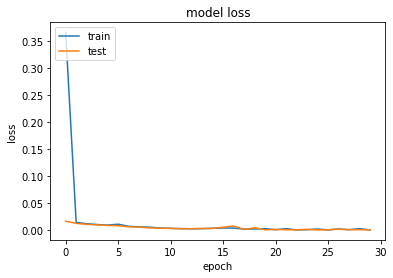

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./graphics/model_loss.png')
plt.show()

## Function to Check Reconstructed Photos

In [29]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

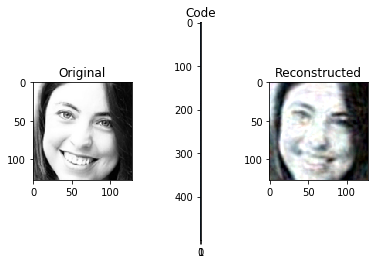

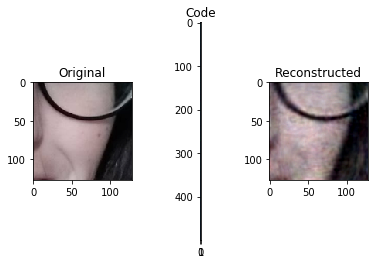

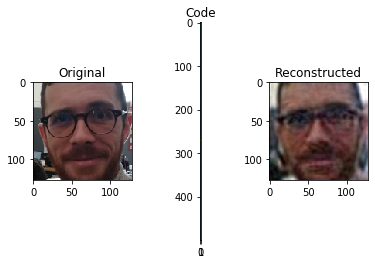

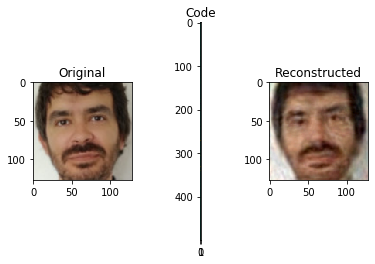

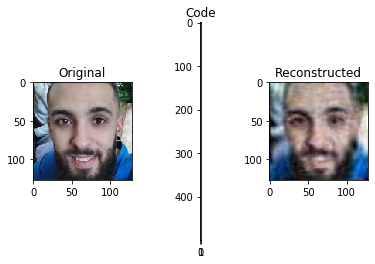

IndexError: index 5 is out of bounds for axis 0 with size 5

In [36]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
   
    plt.show()
for i in range(6):
    img = X_test[i]
    visualize(img,encoder,decoder)

## Function to test the model with friends photos

In [31]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [32]:
def load_dataset(path):
    img_data_list=[]
    data_path = path

    data_dir_list = os.listdir(data_path)
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
            #input_img_resize=cv2.resize(input_img,(64,64))
            faces = face_cascade.detectMultiScale(input_img, 1.1, 3)
            print (faces[0])
            input_img_resize=cv2.resize(input_img,(128,128))
            x,y,w,h = faces[0]
            print(x,y,w,h)
            face = input_img[y:y+h,x:x+w]
            face=cv2.resize(face,(128,128))
            #face = np.expand_dims(faces, axis=1)
            img_data_list.append(face)

    img_data = np.stack(img_data_list).astype('uint8')
    #img_data = img_data.astype('float32')
    return img_data

In [33]:
X = load_dataset("../data/fotop/")
X = X / 255.0 - 0.5
X.shape

Loaded the images of dataset-Clara

[172  62 141 141]
172 62 141 141
Loaded the images of dataset-Cris

[862 816 191 191]
862 816 191 191
Loaded the images of dataset-Cesar

[216 220 247 247]
216 220 247 247
Loaded the images of dataset-Julio

[ 44  25 102 102]
44 25 102 102
Loaded the images of dataset-Alex

[137 152 299 299]
137 152 299 299


(5, 128, 128, 3)

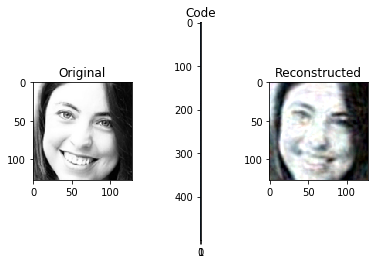

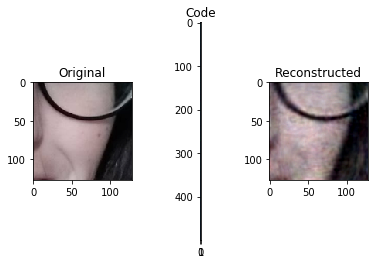

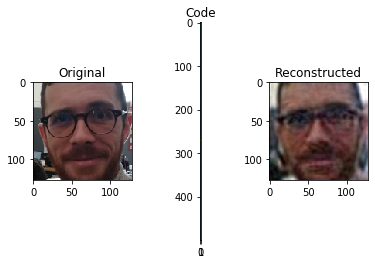

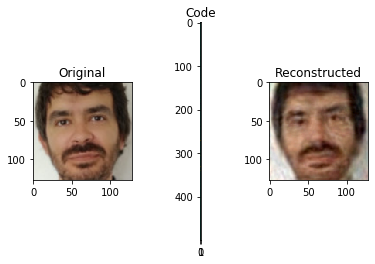

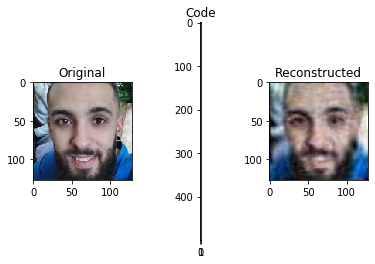

In [34]:
for i in range(5):
    img = X[i]
    visualize(img,encoder,decoder)

In [35]:
img = X[3]
img.shape

(128, 128, 3)

In [ ]:
#code = encoder.predict(img)[0]
#plt.imshow(Image.fromarray(img.squeeze()*255),'gray')
embedded = encoder.predict(np.expand_dims(img, axis=0))[0]
print(embedded.shape)


In [ ]:
print embedded